In [71]:
import sqlite3 as sq
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [40]:
conn = sq.connect("plitech_database.db")
cur = conn.cursor()
df = pd.read_sql_query('select * from recap',conn)
conn.close()

In [41]:
df.total_frais_pliage.sum()

1232300

In [45]:
df['qty_tole'] = df.qty*df.longueur*df.largeur/2000000
df.head(10)

,qty,is_plain,longueur,largeur,type,epaisseur,nom_client,date_arrivé,heure_arrivé,total_vente_tole,total_frais_pliage,total_remise,total_chute,num_facture,qty_tole
0,1,Non,2000,1000,TPN,8/10,RAHERY,2023-06-01,18:20:00,0,18000,0,0.000,53,1.000
1,1,Non,2000,1000,TPN,8/10,RAHERY,2023-06-01,09:45:00,0,18000,0,0.000,54,1.000
2,2,Non,2000,1000,TPN,7/10,MANAMPY,2023-06-01,18:23:00,0,20000,0,0.000,55,2.000
3,1,Oui,1000,1000,TPN,15/10,ZO,2023-06-06,18:24:00,0,15000,0,0.000,56,0.500
4,6,Oui,2500,1250,TPP,30/100,TIANA,2023-06-08,18:27:00,0,54000,0,0.000,57,9.375
5,1,Non,2000,1000,TPN,15/10,SANTATRA,2023-06-08,18:30:00,0,31200,0,0.213,58,1.000
6,1,Non,2000,1000,TPN,8/10,RAHERY,2023-06-09,08:56:00,0,19500,0,0.000,59,1.000
7,1,Non,2000,1000,TPN,8/10,KEVIN,2023-06-09,18:32:00,0,12000,0,0.000,60,1.000
8,3,Non,2000,1000,TPN,10/10,LIVA,2023-06-09,13:00:00,0,36000,0,0.000,61,3.000
9,1,Non,2000,1000,TPN,7/10,FANILO,2023-06-12,09:15:00,0,12000,0,0.000,62,1.000


In [59]:
df1 = df.groupby(["nom_client","date_arrivé","heure_arrivé"]).agg({'qty_tole':sum,"total_vente_tole":'mean',	"total_frais_pliage":'mean',	"total_remise":'mean',	"total_chute":'mean'}).reset_index()
df1['frais_pliage_by_tole'] = df.total_frais_pliage/df.qty_tole
df1


,nom_client,date_arrivé,heure_arrivé,qty_tole,total_vente_tole,total_frais_pliage,total_remise,total_chute,moyenne
0,BOLIDA,2023-06-13,18:36:00,0.400000,0.0,20000.0,0.0,0.00000,18000.000000
1,BOSCO,2023-06-19,19:01:00,15.000000,0.0,60000.0,0.0,0.00000,18000.000000
2,BOSCO,2023-06-30,19:31:00,11.000000,0.0,50600.0,0.0,0.00000,10000.000000
3,CHELAH,2023-06-16,19:00:00,0.390000,0.0,9400.0,0.0,0.00000,30000.000000
4,ELYSEE,2023-06-16,18:58:00,1.000000,97000.0,15000.0,0.0,0.35000,5760.000000
5,FANILO,2023-06-12,09:15:00,1.000000,0.0,12000.0,0.0,0.00000,31200.000000
6,FANILO,2023-06-23,15:14:00,2.000000,0.0,30000.0,0.0,0.00000,19500.000000
7,JAMES,2023-07-03,19:42:00,0.480600,0.0,4800.0,0.0,0.12636,12000.000000
8,JOHARY,2023-06-16,18:56:00,0.091140,0.0,32000.0,0.0,0.00000,12000.000000
9,KEVIN,2023-06-09,18:32:00,1.000000,0.0,12000.0,0.0,0.00000,12000.000000


In [55]:
(df1.total_frais_pliage/df1.qty_tole).mean()
#df1.total_frais_pliage.sum()

24341.365874389394

In [57]:
(df1.qty_tole-df1.total_chute).sum()

101.8183175

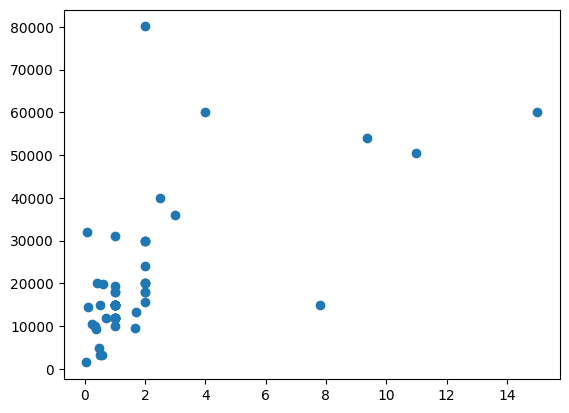

In [58]:
plt.scatter(df1.qty_tole,df1.total_frais_pliage)

In [18]:
df.columns

Index(['qty', 'is_plain', 'longueur', 'largeur', 'type', 'epaisseur',
       'nom_client', 'date_arrivé', 'heure_arrivé', 'total_vente_tole',
       'total_frais_pliage', 'total_remise', 'total_chute', 'num_facture',
       'qty_tole', 'moyenne'],
      dtype='object')

In [60]:
df1.moyenne.mean()

34258.20877847051

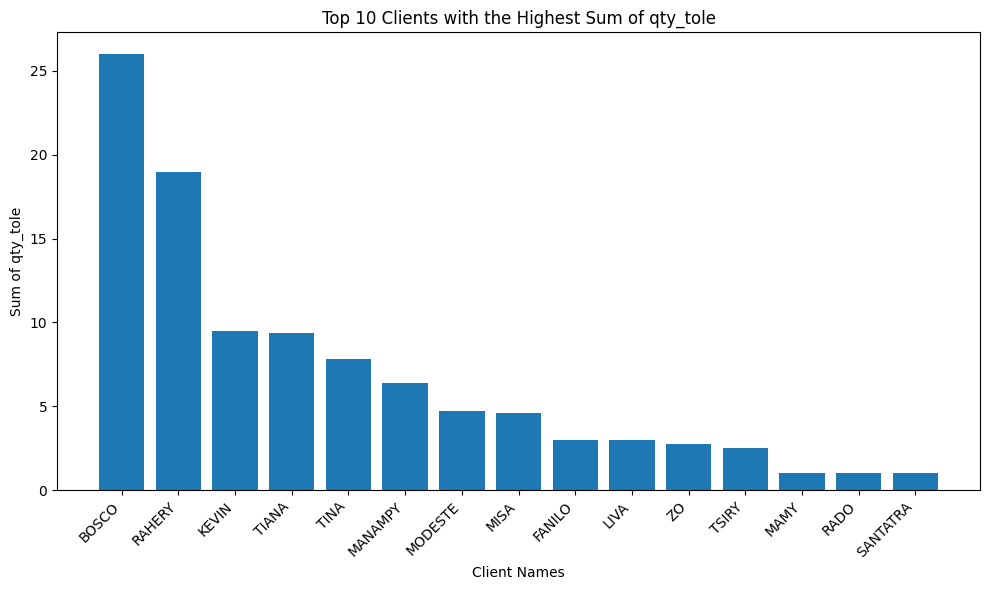

In [62]:
grouped_data = df1.groupby('nom_client')['qty_tole'].sum()

# Sort the data in descending order and select the top 10 clients
top_10_clients = grouped_data.sort_values(ascending=False).head(15)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients.index, top_10_clients.values)
plt.xlabel('Client Names')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Clients with the Highest Sum of qty_tole')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

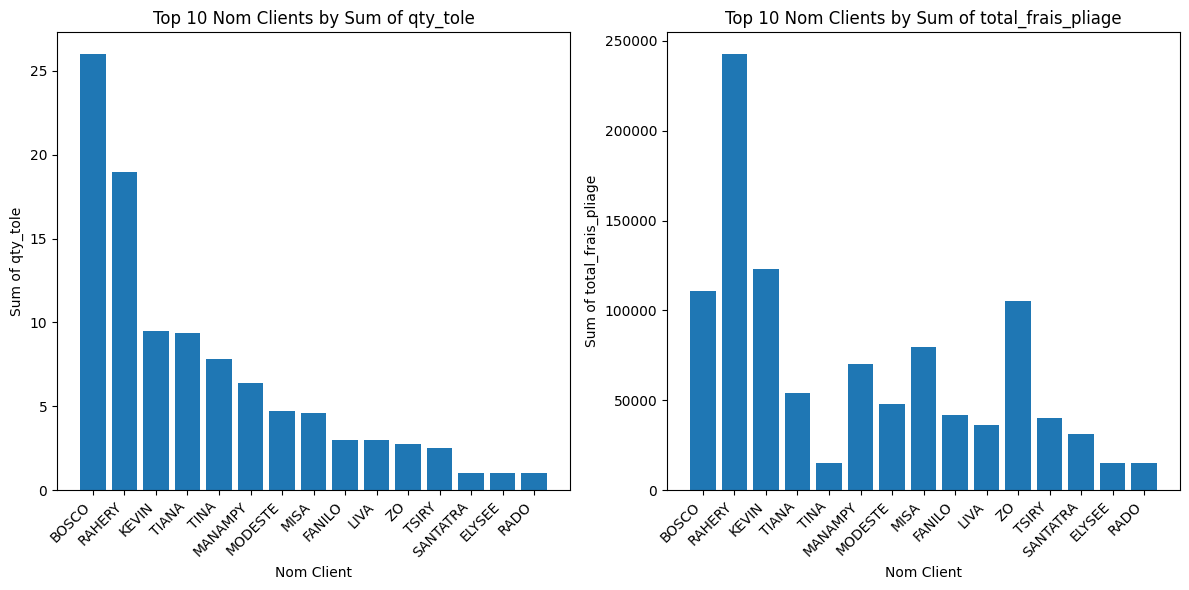

In [65]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_qty_tole = grouped_data['qty_tole'].sum()
sum_total_frais_pliage = grouped_data['total_frais_pliage'].sum()

# Step 3: Combine the sums into a new DataFrame
sum_df = pd.DataFrame({
    'sum_qty_tole': sum_qty_tole,
    'sum_total_frais_pliage': sum_total_frais_pliage
})

# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(by=['sum_qty_tole', 'sum_total_frais_pliage'], ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(15)

# Step 6: Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(top_10_clients.index, top_10_clients['sum_qty_tole'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nom Client')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Nom Clients by Sum of qty_tole')

plt.subplot(1, 2, 2)
plt.bar(top_10_clients.index, top_10_clients['sum_total_frais_pliage'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Nom Client')
plt.ylabel('Sum of total_frais_pliage')
plt.title('Top 10 Nom Clients by Sum of total_frais_pliage')

plt.tight_layout()
plt.show()


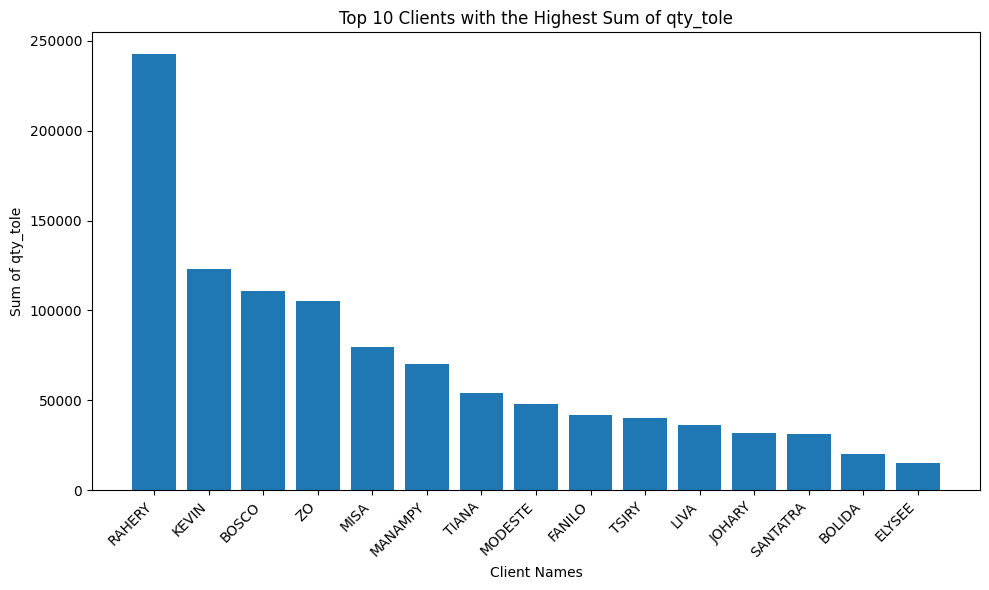

In [67]:
grouped_data = df1.groupby('nom_client')['total_frais_pliage'].sum()

# Sort the data in descending order and select the top 10 clients
top_10_clients = grouped_data.sort_values(ascending=False).head(15)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(top_10_clients.index, top_10_clients.values)
plt.xlabel('Client Names')
plt.ylabel('Sum of qty_tole')
plt.title('Top 10 Clients with the Highest Sum of qty_tole')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [70]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_qty_tole = grouped_data['qty_tole'].sum()
sum_total_frais_pliage = grouped_data['total_frais_pliage'].sum()

# Step 3: Combine the sums into a new DataFrame
sum_df = pd.DataFrame({
    'sum_qty_tole': sum_qty_tole,
    'sum_total_frais_pliage': sum_total_frais_pliage
}).reset_index()

# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(by=['sum_total_frais_pliage','sum_qty_tole' ], ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(10)

# Step 6: Plot the results using Plotly Express
fig = px.bar(top_10_clients, x='nom_client', y=['sum_qty_tole', 'sum_total_frais_pliage'],
             title='Top 10 Nom Clients by Sum of qty_tole and total_frais_pliage',
             labels={'value': 'Sum'}, barmode='group')

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [72]:
grouped_data = df1.groupby('nom_client')

# Step 2: Calculate the sum of 'qty_tole' and 'total_frais_pliage' for each 'nom_client'
sum_qty_tole = grouped_data['qty_tole'].sum()
sum_total_frais_pliage = grouped_data['total_frais_pliage'].sum()

# Step 3: Combine the sums into a new DataFrame
sum_df = pd.DataFrame({
    'sum_qty_tole': sum_qty_tole,
    'sum_total_frais_pliage': sum_total_frais_pliage
}).reset_index()

# Step 4: Sort the data based on the calculated sums in descending order
sum_df = sum_df.sort_values(by=['sum_qty_tole', 'sum_total_frais_pliage'], ascending=False)

# Step 5: Extract the top 10 'nom_client' based on the sums
top_10_clients = sum_df.head(10)

# Step 6: Plot the results using Plotly Express
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Bar(x=top_10_clients['nom_client'], y=top_10_clients['sum_total_frais_pliage'],
                     name='Sum of total_frais_pliage'), secondary_y=False)
fig.add_trace(go.Bar(x=top_10_clients['nom_client'], y=top_10_clients['sum_qty_tole'],
                     name='Sum of qty_tole'), secondary_y=True)

fig.update_layout(title='Top 10 Nom Clients by Sum of qty_tole and total_frais_pliage',
                  xaxis_tickangle=-45, xaxis_title='Nom Client', barmode='group')

fig.update_yaxes(title_text='Sum of total_frais_pliage', secondary_y=False)
fig.update_yaxes(title_text='Sum of qty_tole', secondary_y=True)

fig.show()

In [73]:
df1.nom_client.value_counts()

nom_client
RAHERY      17
KEVIN        8
MANAMPY      4
MODESTE      3
ZO           3
FANILO       2
BOSCO        2
MISA         2
JAMES        1
JOHARY       1
LIVA         1
MAMY         1
ELYSEE       1
RADO         1
CHELAH       1
ROBINSON     1
SANTATRA     1
TIANA        1
TINA         1
TSIRY        1
BOLIDA       1
Name: count, dtype: int64